# Merging data

This notebook contains the preprocessing pipline for cross-species cell-type annotation. 

0) Select and download relevant datasets
1) Condense similar annotation info into same obs columns
2) Map gene variables to homologus gene variables
3) QC + Basic Filtering
4) Normalization + log1p
5) Select HVGs
6) Subset each dataset.var by only shared genes by at least 2 species
7) Merge datasets (outer merge to conserve obs-metadata, fill NaN with 0)

Available kernel & conda env: `scanpy-env`


In [1]:
import os
import glob
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from scipy.stats import entropy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from collections import Counter

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

## Mouse Dataset

Tasic, B., Menon, V., Nguyen, T. N., Kim, T. K., Jarsky, T., Yao, Z., Levi, B., Gray, L. T., Sorensen, S. A., Dolbeare, T., Bertagnolli, D., Goldy, J., Shapovalova, N., Parry, S., Lee, C., Smith, K., Bernard, A., Madisen, L., Sunkin, S. M., Hawrylycz, M., … Zeng, H. (2016). Adult mouse cortical cell taxonomy revealed by single cell transcriptomics. Nature neuroscience, 19(2), 335–346. https://doi.org/10.1038/nn.4216

https://figshare.com/articles/dataset/allen_brain_h5ad/20338089?file=36509385

First, we'll download the mouse brain database and upload it into the server

In [3]:
!mkdir -p /home/raquelcr/scanpy/ann_datasets

In [4]:
# must be 1.0G
!du -h /home/raquelcr/scanpy/ann_datasets/allen_brain.h5ad

978M	/home/raquelcr/scanpy/ann_datasets/allen_brain.h5ad


In [3]:
mouse_data = sc.read('/home/raquelcr/scanpy/ann_datasets/allen_brain.h5ad')

In [4]:
mouse_data.shape

(14249, 34617)

In [5]:
# Create species column
mouse_data.obs['species'] = 'mouse'

In [6]:
# Load gene otholog reference table (adapted with `gene_reference.ipynb`)
gene_reference = pd.read_csv('/home/raquelcr/scanpy/gene_reference.csv')
gene_reference.head()

,NMR gene name,gene_ids,Human gene stable ID,Human gene name,Mouse gene stable ID,Mouse gene name,Local_ID,Global_name,Global_ID
0,ZMYND10,ENSHGLG00000010267,ENSG00000004838,ZMYND10,ENSMUSG00000010044,Zmynd10,LOCAL00000000000,ZMYND10,ENSHGLG00000010267
1,AMIGO3,ENSHGLG00000010542,NaN,NaN,NaN,NaN,LOCAL00000000001,AMIGO3,ENSHGLG00000010542
2,TNFSF10,ENSHGLG00000010558,NaN,NaN,NaN,NaN,LOCAL00000000002,TNFSF10,ENSHGLG00000010558
3,ENSHGLG00000010617,ENSHGLG00000010617,NaN,NaN,NaN,NaN,LOCAL00000000003,ENSHGLG00000010617,ENSHGLG00000010617
4,NPRL2,ENSHGLG00000010655,ENSG00000114388,NPRL2,ENSMUSG00000010057,Nprl2,LOCAL00000000004,NPRL2,ENSHGLG00000010655


In [7]:
# Map mouse gene names to global names using gene_reference
mouse_gene_map = dict(zip(gene_reference['Mouse gene name'], gene_reference['Global_name']))
mouse_data.var['global_name'] = mouse_data.var_names.map(mouse_gene_map)


In [8]:
print(f"Genes with global name: {mouse_data.var['global_name'].notnull().sum()}")
print(f"Genes without global name: {mouse_data.var['global_name'].isnull().sum()}")
mouse_data.var.head(10) # Lots of genes do not have an homologus.

Genes with global name: 8938
Genes without global name: 25679


,n_cells,global_name
0610005C13Rik,334,NaN
0610006L08Rik,17,NaN
0610007P14Rik,13189,NaN
0610009B22Rik,12943,NaN
0610009E02Rik,1474,NaN
0610009L18Rik,5025,NaN
0610009O20Rik,8127,NaN
0610010B08Rik,22,NaN
0610010F05Rik,12139,NaN
0610010K14Rik,13170,C17orf49


In [9]:
print(f"{str(mouse_data.var['global_name'].notna().sum())} out of {mouse_data.var.shape[0]} genes mapped to global names.")

8938 out of 34617 genes mapped to global names.


In [10]:
print(f"There are {len(mouse_data.obs[mouse_data.obs['label']!= mouse_data.obs['subclass']])} cells where label and subclass do not match.")

There are 0 cells where label and subclass do not match.


In [11]:
mouse_annotations = pd.DataFrame(mouse_data.obs['label'].unique(), columns=['mouse_types'])
mouse_annotations.head()

,mouse_types
0,Vip
1,Lamp5
2,Sst
3,Sncg
4,Serpinf1


### Mapping mouse to human celltypes

cluster_annotation.xlsx was provided by the Linnarson Lab. It describes the cluster annotation of the whole human adult dataset
See on https://github.com/linnarsson-lab/adult-human-brain/blob/main/tables/cluster_annotation.xlsx 

#### Notes:

- Some mouse subtypes (like Meis2, Serpinf1, Sncg) don’t have a 1:1 equivalent in the human label set. They were mapped to the closest CGE/Misc categories.

- Vascular cells (Endo, Peri, VLMC, SMC) were mapped to corresponding endothelial, pericyte, fibroblast, and smooth muscle populations in human.

- Excitatory neurons (L2/3 IT, L4, L5 IT/PT, L6 IT/CT/6b) were mapped to the corresponding human excitatory classes (ULIT, DLIT, DLNP, DLCT6b, L5ET).

In [12]:
human_anot = pd.read_excel('/home/raquelcr/scanpy/ann_datasets/cluster_annotation.xlsx', )
human_anot.dropna(how='all',inplace=True)
human_anot['Cluster ID'] = [int(k) for k in human_anot['Cluster ID']]
human_anot.set_index('Cluster ID', inplace=True)
human_anot.sort_values('Number of cells', ascending=False)['Number of cells']

Cluster ID
47     124837.0
45     109325.0
44     101039.0
311     97038.0
49      84282.0
         ...   
75         70.0
29         63.0
408        45.0
314        42.0
297        34.0
Name: Number of cells, Length: 461, dtype: float64

In [13]:
## needs revision
mouse2human = {
    # Inhibitory neuron types
    "Vip": "CGE_276",          # VIP interneurons (CGE-derived)
    "Lamp5": "CGE_277",        # LAMP5 interneurons (neurogliaform, CGE)
    "Sst": "MGE_236",          # SST interneurons (MGE-derived)
    "Sncg": "CGE_278",         # SNCG-positive interneurons (CGE small subset)
    "Serpinf1": "CGE_279",     # Another CGE-related population
    "Pvalb": "MGE_239",        # Parvalbumin interneurons (MGE)

    # Non-neuronal vasculature-related
    "Endo": "VendAC_14",       # Endothelial (choose one vascular subtype)
    "Peri": "Per_21",          # Pericytes
    "SMC": "Vsmc_19",          # Smooth muscle cells
    "VLMC": "Fbl_24",          # Vascular/leptomeningeal fibroblast

    # Excitatory cortical neurons
    "L6.CT": "DLCT6b_84",      # Layer 6 corticothalamic
    "L6b": "DLCT6b_97",        # Layer 6b
    "L6.IT": "DLIT_136",       # Layer 6 intratelencephalic
    "L2.3.IT": "ULIT_120",     # Upper-layer 2/3 intratelencephalic
    "L5.PT": "L5ET_113",       # Layer 5 pyramidal tract
    "L5.IT": "ULIT_133",       # Layer 5 intratelencephalic
    "L4": "DLNP_83",           # Layer 4 excitatory (NP-like)
    "NP": "DLNP_85",           # Near-projecting (layer 5 NP subtype)
    "CR": "Misc_116",          # Cajal-Retzius cells → not well represented, put in Misc

    # Glia
    "Oligo": "Oligo_40",       # Oligodendrocytes
    "Astro": "Astro_52",       # Astrocytes
    "Macrophage": "Mono_3",    # Brain macrophages/microglia
    "Meis2": "Misc_132"        # Rare Meis2+ interneuron → map to Misc
}
mouse_data.obs['cell_type'] = mouse_data.obs['label'].map(mouse2human)
mouse_data.obs['cell_type'].value_counts()

cell_type
DLIT_136     1872
MGE_236      1741
CGE_276      1728
DLNP_83      1401
MGE_239      1337
CGE_277      1122
ULIT_120      982
DLCT6b_84     960
ULIT_133      880
L5ET_113      544
Astro_52      368
DLNP_85       362
DLCT6b_97     358
CGE_278       125
VendAC_14      94
Oligo_40       91
Fbl_24         67
Vsmc_19        55
Mono_3         51
Misc_132       45
Per_21         32
CGE_279        27
Misc_116        7
Name: count, dtype: int64

In [14]:
# Map mouse gene names to supercluster using human_anot
supercluster_map = dict(zip(human_anot['Cluster name'], human_anot['Supercluster']))
mouse_data.obs['cell_supertype'] = mouse_data.obs['cell_type'].map(supercluster_map)

mouse_data.obs

,label,sizeFactor,subclass,n_counts,species,cell_type,cell_supertype
F1S4_160108_001_A01,Vip,1.085313,Vip,1730700.0,mouse,CGE_276,CGE interneuron
F1S4_160108_001_B01,Lamp5,1.197503,Lamp5,1909605.0,mouse,CGE_277,CGE interneuron
F1S4_160108_001_C01,Lamp5,1.244751,Lamp5,1984948.0,mouse,CGE_277,CGE interneuron
F1S4_160108_001_D01,Vip,1.437020,Vip,2291552.0,mouse,CGE_276,CGE interneuron
F1S4_160108_001_E01,Lamp5,1.102096,Lamp5,1757463.0,mouse,CGE_277,CGE interneuron
...,...,...,...,...,...,...,...
FYS4_171004_104_C01,L5.PT,0.595336,L5.PT,949356.0,mouse,L5ET_113,Miscellaneous
FYS4_171004_104_D01,Sst,0.626302,Sst,998736.0,mouse,MGE_236,MGE interneuron
FYS4_171004_104_F01,L5.PT,0.628829,L5.PT,1002766.0,mouse,L5ET_113,Miscellaneous
FYS4_171004_104_G01,Sst,0.643276,Sst,1025804.0,mouse,MGE_236,MGE interneuron


## Human dataset

Siletti, K., Hodge, R., Mossi Albiach, A., Lee, K. W., Ding, S.-L., Hu, L., Lönnerberg, P., Bakken, T., Casper, T., Clark, M., Dee, N., Gloe, J., Hirschstein, D., Shapovalova, N. V., Keene, C. D., Nyhus, J., Tung, H., Yanny, A. M., Arenas, E., … Linnarsson, S. (2023). **Transcriptomic diversity of cell types across the adult human brain.** Science, 382(6667), eadd7046. https://doi.org/10.1126/science.add7046

https://www.biorxiv.org/content/10.1101/2022.10.12.511898v1.full.pdf



In [15]:
# Download if it doesn't exists
if os.path.exists('/home/raquelcr/scanpy/ann_datasets/human_adult_GRCh38-3.0.0.h5ad')!= True:
    !wget -O /home/raquelcr/scanpy/ann_datasets/human_adult_GRCh38-3.0.0.h5ad 'https://storage.googleapis.com/linnarsson-lab-human/human_adult_GRCh38-3.0.0.h5ad'
else:
    print("File already exists")

File already exists


In [16]:
# must be 27G
!du -h '/home/raquelcr/scanpy/ann_datasets/human_adult_GRCh38-3.0.0.h5ad'

27G	/home/raquelcr/scanpy/ann_datasets/human_adult_GRCh38-3.0.0.h5ad


### Sampling a reference human dataset

`human_aldult_GRCh38-3.0.0.h5ad` contains the gene expresssion matrix of 3,369,219 cells and 33,538 genes. In order to use it as a reference, we can sample a subset of the whole dataset to decrease computation resources needed to perform calculation. Only a fraction of randomly selected data is considered in this analysis and 34 cells per cluster were added to improve represtability of low number of cells clusters. 

In [17]:
# Stratified sampling to ensure all clusters are represented
# Takes around 10 minutes to run
def subsample_dataset(dataset_path,random_seed=71, fraction=0.02, min_per_cluster=34):
    dirname = os.path.dirname(dataset_path)
    basename = os.path.basename(dataset_path)
    subset_path = os.path.join(dirname,f"{basename.split(r'[-.]')[0]}_subset{random_seed}.h5ad")

    if os.path.exists(subset_path):
        print("Loading existing subset...")
        human_data = sc.read(subset_path)
        print(f"Sampled dataset: {human_data.shape[0]} × {human_data.shape[1]}")
        return human_data
    else:
        print("Creating new subset...")

        # Step 1. Open dataset in backed mode
        adata_backed = sc.read_h5ad(dataset_path, backed="r")

        n_cells = adata_backed.n_obs
        target_size = int(n_cells * fraction)
        print(f"Original: {n_cells} cells, target {target_size}")

        # Step 2. Get cluster info
        clusters = adata_backed.obs["cluster_id"].astype(str)

        np.random.seed(random_seed)
        sampled_indices = []
        summary = []  # collect stats

        # Step 3. Stratified sampling per cluster
        for clust, idx in clusters.groupby(clusters).groups.items():
            idx = np.array(list(idx))  # indices for this cluster
            n_total = len(idx)

            # desired sample = 5% + 34, but not more than available
            n_sample = int(n_total * fraction) + min_per_cluster
            n_sample = min(n_sample, n_total)

            chosen = np.random.choice(idx, size=n_sample, replace=False)
            sampled_indices.extend(chosen)

            summary.append([clust, n_total, n_sample])

        # Step 4. Load only sampled cells into memory
        human_data = sc.read_h5ad(dataset_path)[sampled_indices, :].copy()

        print(f"Final sampled dataset: {human_data.shape[0]} × {human_data.shape[1]}")

        # Step 5. Print per-cluster summary
        df_summary = pd.DataFrame(summary, columns=["cluster_id", "total_cells", "sampled_cells"])
        df_summary["fraction_sampled"] = df_summary["sampled_cells"] / df_summary["total_cells"]
        print(df_summary.sort_values("total_cells").head(20))  # show smallest clusters
        print("...")
        print(df_summary.sort_values("total_cells", ascending=False).head(20))  # show largest clusters

        # Step 6. Save the subset
        human_data.write_h5ad(subset_path)
        print(f"Sampled dataset saved to {subset_path}")
        return human_data


In [18]:
human_data = subsample_dataset('/home/raquelcr/scanpy/ann_datasets/human_adult_GRCh38-3.0.0.h5ad'
                               ,random_seed=71, fraction=0.02, min_per_cluster=34)

Loading existing subset...
Only considering the two last: ['.h5ad_subset71', '.h5ad'].
Only considering the two last: ['.h5ad_subset71', '.h5ad'].
Sampled dataset: 82836 × 33538


In [19]:
# See obtained cluster representation
human_data.obs['cluster_id'] = human_data.obs['cluster_id'].astype('category')
human_data.obs.groupby('cluster_id').count()['roi'].sort_values(ascending=False)

cluster_id
47     2530
45     2220
44     2054
311    1974
49     1719
       ... 
75       35
29       35
297      34
314      34
408      34
Name: roi, Length: 461, dtype: int64

In [20]:
human_anot.head(2)

,Cluster name,Supercluster,Class auto-annotation,Neurotransmitter auto-annotation,Neuropeptide auto-annotation,Subtype auto-annotation,Transferred MTG Label,Top three regions,Top three dissections,Top Enriched Genes,...,DoubletFinder score,Total UMI,Fraction unspliced,Fraction mitochondrial,H19.30.002,H19.30.001,H18.30.002,H18.30.001,Fraction cells from top donor,Number of donors
Cluster ID,,,,,,,,,,,,,,,,,,,,,
0,Bcell_0,Miscellaneous,BCELL,NaN,NaN,NaN,NaN,"Midbrain: 21.0%, Basal forebrain: 19.0%, Pons:...","Human GPi: 11.4%, Human SN: 11.4%, Human SN-RN...","IGHM, MS4A1, FCRL1, AC244205.1, IGLL5, IGHA1, ...",...,0.013358,2258.866667,0.608113,0.020989,58.0,20.0,27.0,0.0,0.552381,3.0
1,Tcell_1,Miscellaneous,TCELL,NaN,NaN,NaN,NaN,"Midbrain: 15.0%, Basal forebrain: 14.0%, Pons:...","Human SpC: 8.2%, Human CbDN: 7.6%, Human SN: 7.4%","CD2, IL7R, PTPRC, SLFN12L, IL32, CCL5, GRAP2, ...",...,0.022371,2184.314470,0.582884,0.021212,708.0,400.0,1364.0,2.0,0.551334,4.0


In [21]:
human_data.obs.head(2)

,Tissue,TotalUMIs,organism_ontology_term_id,disease_ontology_term_id,self_reported_ethnicity_ontology_term_id,assay_ontology_term_id,sex_ontology_term_id,development_stage_ontology_term_id,donor_id,suspension_type,dissection,total_UMIs,sample_id,cluster_id,roi
CellID,,,,,,,,,,,,,,,
10X393_3:CCACACTGTTCACGAT,Tail of Hippocampus (HiT) - Caudal Hippocampus...,1272,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000123,H19.30.002,nucleus,Tail of Hippocampus (HiT) - Caudal Hippocampus...,1272,10X393_3,0,CA4C-DGC
10X225_2:CATGCGGCACAGTGTT,Midbrain (M) - Periaqueductal gray and nearby ...,984,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000144,H18.30.002,nucleus,Midbrain (M) - Periaqueductal gray and nearby ...,984,10X225_2,0,PAG


In [22]:
# Map human gene names to supercluster using human_anot
cluster_map = dict(zip(human_anot.index, human_anot['Cluster name']))
human_data.obs['cell_type'] = human_data.obs['cluster_id'].map(cluster_map)
human_data.obs['cell_supertype'] = human_data.obs['cell_type'].map(supercluster_map)

human_data.obs

,Tissue,TotalUMIs,organism_ontology_term_id,disease_ontology_term_id,self_reported_ethnicity_ontology_term_id,assay_ontology_term_id,sex_ontology_term_id,development_stage_ontology_term_id,donor_id,suspension_type,dissection,total_UMIs,sample_id,cluster_id,roi,cell_type,cell_supertype
CellID,,,,,,,,,,,,,,,,,
10X393_3:CCACACTGTTCACGAT,Tail of Hippocampus (HiT) - Caudal Hippocampus...,1272,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000123,H19.30.002,nucleus,Tail of Hippocampus (HiT) - Caudal Hippocampus...,1272,10X393_3,0,CA4C-DGC,Bcell_0,Miscellaneous
10X225_2:CATGCGGCACAGTGTT,Midbrain (M) - Periaqueductal gray and nearby ...,984,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000144,H18.30.002,nucleus,Midbrain (M) - Periaqueductal gray and nearby ...,984,10X225_2,0,PAG,Bcell_0,Miscellaneous
10X241_8:AGATGAAGTTTGCAGT,Cerebral cortex (Cx) - Middle Temporal Gyrus -...,0,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000123,H19.30.002,nucleus,Cerebral cortex (Cx) - Middle Temporal Gyrus -...,0,10X241_8,0,MTG,Bcell_0,Miscellaneous
10X203_1:TGAGGAGCAGAGATTA,Thalamus (THM) - intralaminar nuclear complex ...,2425,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000144,H18.30.002,nucleus,Thalamus (THM) - intralaminar nuclear complex ...,2425,10X203_1,0,CM,Bcell_0,Miscellaneous
10X182_1:AAGAACAAGCCAACCC,Cerebral cortex (Cx) - Posterior parahippocamp...,3031,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000144,H18.30.002,nucleus,Cerebral cortex (Cx) - Posterior parahippocamp...,3031,10X182_1,0,TH-TL,Bcell_0,Miscellaneous
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10X190_1:ACAAAGAGTAGTGATA,Paleocortex (PalCx) - Piriform cortex - Pir,29219,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000144,H18.30.002,nucleus,Paleocortex (PalCx) - Piriform cortex - Pir,29219,10X190_1,99,Pir,DLCT6b_99,Deep-layer corticothalamic and 6b
10X146_7:AAGTGAATCCGCTAGG,Cerebral cortex (Cx) - Frontal agranular insul...,97186,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000144,H18.30.002,nucleus,Cerebral cortex (Cx) - Frontal agranular insul...,97186,10X146_7,99,FI,DLCT6b_99,Deep-layer corticothalamic and 6b
10X173_7:ATACTTCGTAGCCAGA,"Cerebral cortex (Cx) - Cuneus, rostral part - ...",39630,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000144,H18.30.002,nucleus,"Cerebral cortex (Cx) - Cuneus, rostral part - ...",39630,10X173_7,99,Pro,DLCT6b_99,Deep-layer corticothalamic and 6b


In [23]:
# Add species column
human_data.obs['species'] = 'human'
human_data.obs.head(2)

,Tissue,TotalUMIs,organism_ontology_term_id,disease_ontology_term_id,self_reported_ethnicity_ontology_term_id,assay_ontology_term_id,sex_ontology_term_id,development_stage_ontology_term_id,donor_id,suspension_type,dissection,total_UMIs,sample_id,cluster_id,roi,cell_type,cell_supertype,species
CellID,,,,,,,,,,,,,,,,,,
10X393_3:CCACACTGTTCACGAT,Tail of Hippocampus (HiT) - Caudal Hippocampus...,1272,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000123,H19.30.002,nucleus,Tail of Hippocampus (HiT) - Caudal Hippocampus...,1272,10X393_3,0,CA4C-DGC,Bcell_0,Miscellaneous,human
10X225_2:CATGCGGCACAGTGTT,Midbrain (M) - Periaqueductal gray and nearby ...,984,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,PATO:0000384,HsapDv:0000144,H18.30.002,nucleus,Midbrain (M) - Periaqueductal gray and nearby ...,984,10X225_2,0,PAG,Bcell_0,Miscellaneous,human


In [24]:
human_data.var_names

Index(['ENSG00000237613', 'ENSG00000238009', 'ENSG00000239945',
       'ENSG00000239906', 'ENSG00000284733', 'ENSG00000284662',
       'ENSG00000225880', 'ENSG00000230368', 'ENSG00000223764',
       'ENSG00000188976',
       ...
       'ENSG00000228240', 'ENSG00000226906', 'ENSG00000183753',
       'ENSG00000205944', 'ENSG00000227439', 'ENSG00000235412',
       'ENSG00000183795', 'ENSG00000205916', 'ENSG00000172288',
       'ENSG00000231141'],
      dtype='object', name='Accession', length=33538)

In [25]:
# Map human gene names to global names using gene_reference
human_gene_map = dict(zip(gene_reference['Human gene stable ID'], gene_reference['Global_name']))
human_data.var['global_name'] = human_data.var_names.map(human_gene_map)


In [26]:
print(f"{str(human_data.var['global_name'].notna().sum())} out of {human_data.var.shape[0]} genes mapped to global names.")

8497 out of 33538 genes mapped to global names.


In [27]:
human_data.var

,Chromosome,End,Gene,Start,Strand,global_name
Accession,,,,,,
ENSG00000237613,1,36081,FAM138A,34554,-,NaN
ENSG00000238009,1,133723,AL627309.1,89295,-,NaN
ENSG00000239945,1,91105,AL627309.3,89551,-,NaN
ENSG00000239906,1,140339,AL627309.2,139790,-,NaN
ENSG00000284733,1,451697,OR4F29,450703,-,NaN
...,...,...,...,...,...,...
ENSG00000235412,Y,24607025,TTTY4B,24570202,+,NaN
ENSG00000183795,Y,24639207,BPY2B,24607560,+,NaN
ENSG00000205916,Y,24907040,DAZ4,24833843,+,NaN


In [28]:
human_data.shape

(82836, 33538)

In [29]:
print(f"{str(human_data.var['global_name'].notna().sum())} out of {human_data.var.shape[0]} genes mapped to global names.")

8497 out of 33538 genes mapped to global names.


## Developing Human Brain

This dataset contains 1,665,937 cells, so it is recommended to subsample it.

Eze, U.C., Bhaduri, A., Haeussler, M. et al. Single-cell atlas of early human brain development highlights heterogeneity of human neuroepithelial cells and early radial glia. Nat Neurosci 24, 584–594 (2021). https://doi.org/10.1038/s41593-020-00794-1

https://assets.nemoarchive.org/dat-0rsydy7

File: scanpy/ann_datasets/human_dev.h5ad (Must be 12GB)


In [30]:
!du -h /home/raquelcr/scanpy/ann_datasets/human_dev.h5ad

12G	/home/raquelcr/scanpy/ann_datasets/human_dev.h5ad


In [31]:
dev_human = subsample_dataset('/home/raquelcr/scanpy/ann_datasets/human_dev.h5ad'
                               ,random_seed=71, fraction=0.02, min_per_cluster=34)

Loading existing subset...


Sampled dataset: 53981 × 59459


In [32]:
# Add species column
dev_human.obs['species'] = 'human'
dev_human.obs.head(2)

,Age,CellClass,Chemistry,Region,Subregion,organism_ontology_term_id,disease_ontology_term_id,self_reported_ethnicity_ontology_term_id,assay_ontology_term_id,sex_ontology_term_id,...,tissue_ontology_term_id,cell_type_ontology_term_id,fraction_mitochondrial,fraction_unspliced,cell_cycle_score,total_genes,total_UMIs,sample_id,cluster_id,species
CellID,,,,,,,,,,,,,,,,,,,,,
10X186_3:ATCCCTGGTAAGCAAT,12.0,Neuroblast,v3,Hindbrain,Hindbrain,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,unknown,...,UBERON:0002028,CL:0000031,0.083800,0.254985,0.001344,1920,4463,10X186_3,0,human
10X116_4:AGCTCTCAGTTACGGG,9.2,Neuroblast,v2,Medulla,Medulla,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,unknown,...,UBERON:0001896,CL:0000031,0.017705,0.131964,0.008263,1886,4236,10X116_4,0,human


In [33]:
dev2humananot = {
    # Células del Linaje Neuronal
    "Neuroblast": "DLNP_83",  # Neuroblastos son progenitores neuronales. DLNP (Deep Layer Neuronal Progenitor) es un buen representante.
    "Neuronal IPC": "DLIT_136",  # IPC (Intermediate Progenitor Cell). DLIT (Deep Layer Inhibitory Neuron) como un destino específico de un IPC neuronal.
    "Neuron": "L5ET_113",  # Neurona. L5ET (Layer 5 Excitatory Neuron) es un tipo principal de neurona cortical.

    # Células Gliales y Progenitoras
    "Radial glia": "Bgl_51",  # Glía Radial. Bgl (Bergmann Glia) es un tipo de glía radial en el cerebelo, o podemos usar Astro_52 como un subtipo diferenciado (los astrocitos son descendientes de la glía radial).
    "Glioblast": "Astro_52",  # Glioblastos son progenitores gliales, que dan lugar a astrocitos y oligodendrocitos. Astro_52 (Astrocito) es un linaje directo.
    "Oligo": "Oligo_40",  # Oligodendrocito. Oligo_40 es un subtipo de oligodendrocito maduro.

    # Células Inmunes
    "Immune": "Mgl_4",  # Inmune. Mgl (Microglia) es el principal tipo de célula inmune residente del SNC.

    # Células Vasculares y Asociadas
    "Vascular": "VendPLVAP_13",  # Vascular. Vend (Vascular Endothelial cell), la célula endotelial vascular con un marcador específico (PLVAP).

    # Células de Soporte No Neuronales / No Gliales
    "Fibroblast": "Fbl_24",  # Fibroblasto. Fbl (Fibroblast) con una especificación de subtipo.
    "Erythrocyte": "Misc_116",  # Eritrocito. A menudo agrupados en células "Misceláneas" o "Hematopoyéticas" en scRNA-seq de cerebro, ya que no son residentes.

    # Linajes Embrionarios
    "Neural crest": "Per_21",  # Cresta Neural. Algunas células de la cresta neural migran al SNC y dan lugar a Pericitos (Per), que son células murales vasculares.
    "Placodes": "Chrp_76"  # Placodes. Chrp (Choroid Plexus) son epitelios especializados con orígenes neuroectodermales, que podrían ser un representante funcional en un conjunto de datos adulto/desarrollo tardío.
}

In [34]:
dev_human.obs['cell_type'] = dev_human.obs['CellClass'].map(dev2humananot)
dev_human.obs['cell_supertype'] = dev_human.obs['cell_type'].map(supercluster_map)

dev_human.obs

,Age,CellClass,Chemistry,Region,Subregion,organism_ontology_term_id,disease_ontology_term_id,self_reported_ethnicity_ontology_term_id,assay_ontology_term_id,sex_ontology_term_id,...,fraction_mitochondrial,fraction_unspliced,cell_cycle_score,total_genes,total_UMIs,sample_id,cluster_id,species,cell_type,cell_supertype
CellID,,,,,,,,,,,,,,,,,,,,,
10X186_3:ATCCCTGGTAAGCAAT,12.0,Neuroblast,v3,Hindbrain,Hindbrain,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,unknown,...,0.083800,0.254985,0.001344,1920,4463,10X186_3,0,human,DLNP_83,Deep-layer near-projecting
10X116_4:AGCTCTCAGTTACGGG,9.2,Neuroblast,v2,Medulla,Medulla,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,unknown,...,0.017705,0.131964,0.008263,1886,4236,10X116_4,0,human,DLNP_83,Deep-layer near-projecting
10X213_1:AACCCAAGTGCGTTTA,13.0,Neuroblast,v3,Medulla,Medulla,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,unknown,...,0.062768,0.199034,0.001252,2209,5592,10X213_1,0,human,DLNP_83,Deep-layer near-projecting
10X213_1:TACCCGTTCCGGTAAT,13.0,Neuroblast,v3,Medulla,Medulla,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,unknown,...,0.061325,0.270603,0.000879,2386,5691,10X213_1,0,human,DLNP_83,Deep-layer near-projecting
10X157_2:CTGCTGTTCACTGGGC,8.0,Neuroblast,v2,Pons,Pons,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,unknown,...,0.005147,0.152702,0.003432,1794,3497,10X157_2,0,human,DLNP_83,Deep-layer near-projecting
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10X178_3:CCACGTTGTACAAGCG,5.0,Radial glia,v3,Hindbrain,Hindbrain,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009922,unknown,...,0.032374,0.189948,0.017186,4094,10008,10X178_3,99,human,Bgl_51,Bergmann glia
10X124_7:TCATTACAGATGCGAC,6.9,Radial glia,v2,Medulla,Medulla,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,unknown,...,0.006570,0.218169,0.014952,2336,4414,10X124_7,99,human,Bgl_51,Bergmann glia
10X152_7:AGTGTCAGTGGCTCCA,6.7,Radial glia,v2,Medulla,Medulla,NCBITaxon:9606,PATO:0000461,unknown,EFO:0009899,unknown,...,0.010737,0.101277,0.018282,1851,3446,10X152_7,99,human,Bgl_51,Bergmann glia


In [35]:
# Find mito_genes
dev_human.var['mt'] = dev_human.var['Gene'].str.startswith('MT-')
print(f'Found {str(dev_human.var["mt"].sum())} mito genes')

Found 37 mito genes


In [36]:
gene_reference.head(2)

,NMR gene name,gene_ids,Human gene stable ID,Human gene name,Mouse gene stable ID,Mouse gene name,Local_ID,Global_name,Global_ID
0,ZMYND10,ENSHGLG00000010267,ENSG00000004838,ZMYND10,ENSMUSG00000010044,Zmynd10,LOCAL00000000000,ZMYND10,ENSHGLG00000010267
1,AMIGO3,ENSHGLG00000010542,NaN,NaN,NaN,NaN,LOCAL00000000001,AMIGO3,ENSHGLG00000010542


In [37]:
# Drop last part of the Accession to match gene_reference 
dev_human.var['Accession'] = [acc.split('.')[0] if pd.notna(acc) else acc for acc in dev_human.var['Accession']]
dev_human.var

,Accession,Chromosome,End,GeneTotalUMIs,Start,Gene,mt
Accession,,,,,,,
ENSG00000223972.5,ENSG00000223972,chr1,14409,3,11869,DDX11L1,False
ENSG00000227232.5,ENSG00000227232,chr1,29570,104073,14404,WASH7P,False
ENSG00000278267.1,ENSG00000278267,chr1,17436,0,17369,MIR6859-1,False
ENSG00000284332.1,ENSG00000284332,chr1,30503,0,30366,MIR1302-2,False
ENSG00000268020.3,ENSG00000268020,chr1,53312,0,52473,OR4G4P,False
...,...,...,...,...,...,...,...
ENSG00000275757.1,ENSG00000275757,chr22_KI270733v1,174108,0,173956,5_8S_rRNA-8,False
ENSG00000278573.1,ENSG00000278573,chr22_KI270734v1,60316,0,59711,AC007325.3,False
ENSG00000276017.1,ENSG00000276017,chr22_KI270734v1,74814,15,72411,AC007325.1,False


In [38]:
dev_human.var['global_name'] = dev_human.var['Accession'].map(human_gene_map)
dev_human.var['global_name'].notnull().sum() # must not be 0 or near 0

np.int64(8507)

In [39]:
dev_human.var_names = dev_human.var['global_name']
dev_human.var.sort_values('GeneTotalUMIs', ascending=False).head(15)

,Accession,Chromosome,End,GeneTotalUMIs,Start,Gene,mt,global_name
global_name,,,,,,,,
NaN,ENSG00000251562,chr11,65506516,419535869,65497688,MALAT1,False,NaN
Tuba1a,ENSG00000167552,chr12,49189080,82872215,49184795,TUBA1A,False,Tuba1a
NaN,ENSG00000210082,chrM,3229,54470313,1671,MT-RNR2,True,NaN
COX1,ENSG00000198804,chrM,7445,50031188,5904,MT-CO1,True,COX1
NaN,ENSG00000147403,chrX,154409168,47190036,154389955,RPL10,False,NaN
ACTG1,ENSG00000184009,chr17,81523847,46167199,81509971,ACTG1,False,ACTG1
NaN,ENSG00000034510,chr2,84906671,45385699,84905656,TMSB10,False,NaN
NaN,ENSG00000205542,chrX,12977227,45256038,12975110,TMSB4X,False,NaN
COX3,ENSG00000198938,chrM,9990,45054217,9207,MT-CO3,True,COX3


In [40]:
# drop genes without global name
dev_human = dev_human[:, dev_human.var['global_name'].notna()].copy()
dev_human.var_names_make_unique()

In [41]:
dev_human

AnnData object with n_obs × n_vars = 53981 × 8507
    obs: 'Age', 'CellClass', 'Chemistry', 'Region', 'Subregion', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'tissue_type', 'dissection', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'fraction_mitochondrial', 'fraction_unspliced', 'cell_cycle_score', 'total_genes', 'total_UMIs', 'sample_id', 'cluster_id', 'species', 'cell_type', 'cell_supertype'
    var: 'Accession', 'Chromosome', 'End', 'GeneTotalUMIs', 'Start', 'Gene', 'mt', 'global_name'
    uns: 'batch_condition', 'title'
    obsm: 'Factors', 'X_Embedding'
    varm: 'Loadings'

## Naked Mole Rat Datasets

In [42]:
nmr_files = glob.glob('/home/raquelcr/scanpy/cellbender/denoised/*_filtered.h5')
nmr_files

['/home/raquelcr/scanpy/cellbender/denoised/NMR2_cerebral_cortex_denoised_filtered.h5',
 '/home/raquelcr/scanpy/cellbender/denoised/NMR1_cerebral_cortex_denoised_filtered.h5',
 '/home/raquelcr/scanpy/cellbender/denoised/NMR3_hippocampus_denoised_filtered.h5',
 '/home/raquelcr/scanpy/cellbender/denoised/NMR4_hippocampus_denoised_filtered.h5',
 '/home/raquelcr/scanpy/cellbender/denoised/NMR5_midbrain_denoised_filtered.h5',
 '/home/raquelcr/scanpy/cellbender/denoised/NMR6_midbrain_denoised_filtered.h5']

In [43]:
gene_reference

,NMR gene name,gene_ids,Human gene stable ID,Human gene name,Mouse gene stable ID,Mouse gene name,Local_ID,Global_name,Global_ID
0,ZMYND10,ENSHGLG00000010267,ENSG00000004838,ZMYND10,ENSMUSG00000010044,Zmynd10,LOCAL00000000000,ZMYND10,ENSHGLG00000010267
1,AMIGO3,ENSHGLG00000010542,NaN,NaN,NaN,NaN,LOCAL00000000001,AMIGO3,ENSHGLG00000010542
2,TNFSF10,ENSHGLG00000010558,NaN,NaN,NaN,NaN,LOCAL00000000002,TNFSF10,ENSHGLG00000010558
3,ENSHGLG00000010617,ENSHGLG00000010617,NaN,NaN,NaN,NaN,LOCAL00000000003,ENSHGLG00000010617,ENSHGLG00000010617
4,NPRL2,ENSHGLG00000010655,ENSG00000114388,NPRL2,ENSMUSG00000010057,Nprl2,LOCAL00000000004,NPRL2,ENSHGLG00000010655
...,...,...,...,...,...,...,...,...,...
20769,ENSHGLG00000000459,ENSHGLG00000000459,NaN,NaN,NaN,NaN,LOCAL00000020769,ENSHGLG00000000459,ENSHGLG00000000459
20770,ENSHGLG00000000069,ENSHGLG00000000069,NaN,NaN,NaN,NaN,LOCAL00000020770,ENSHGLG00000000069,ENSHGLG00000000069
20771,ENSHGLG00000019630,ENSHGLG00000019630,NaN,NaN,NaN,NaN,LOCAL00000020771,ENSHGLG00000019630,ENSHGLG00000019630
20772,ENSHGLG00000019772,ENSHGLG00000019772,NaN,NaN,NaN,NaN,LOCAL00000020772,ENSHGLG00000019772,ENSHGLG00000019772


In [44]:
nmr_adatas = []
nmr_gene_map = dict(zip(gene_reference['NMR gene name'], gene_reference['Global_name']))

for file in nmr_files:
    # CellBender output should be read with read_10x_h5
    try: 
        adata = sc.read_10x_h5(file)
    except:
        adata = sc.read(file)

    adata.var['species'] = 'nmr'

    sample = file.replace('/home/raquelcr/scanpy/cellbender/denoised/NMR', '').replace('_denoised_filtered.h5', '').split('_', 1)
    sample_id = sample[0]
    tissue = sample[1]

    print(f'Loading sample {sample_id} of {tissue}')

    adata.obs['species'] = 'nmr'
    adata.obs['tissue'] = tissue
    adata.obs['sample_id'] = sample_id
    adata.obs['replicate'] = (int(sample_id)+1)%2+1

    # Map NMR gene IDs to global names
    adata.var['global_name'] = adata.var_names.map(nmr_gene_map)
    
    nmr_adatas.append(adata)

nmr_adatas

Loading sample 2 of cerebral_cortex
Loading sample 1 of cerebral_cortex
Loading sample 3 of hippocampus
Loading sample 4 of hippocampus
Loading sample 5 of midbrain
Loading sample 6 of midbrain


[AnnData object with n_obs × n_vars = 19487 × 20774
     obs: 'species', 'tissue', 'sample_id', 'replicate'
     var: 'gene_ids', 'feature_types', 'genome', 'species', 'global_name',
 AnnData object with n_obs × n_vars = 14268 × 20774
     obs: 'species', 'tissue', 'sample_id', 'replicate'
     var: 'gene_ids', 'feature_types', 'genome', 'species', 'global_name',
 AnnData object with n_obs × n_vars = 6743 × 20774
     obs: 'species', 'tissue', 'sample_id', 'replicate'
     var: 'gene_ids', 'feature_types', 'genome', 'species', 'global_name',
 AnnData object with n_obs × n_vars = 8179 × 20774
     obs: 'species', 'tissue', 'sample_id', 'replicate'
     var: 'gene_ids', 'feature_types', 'genome', 'species', 'global_name',
 AnnData object with n_obs × n_vars = 7369 × 20774
     obs: 'species', 'tissue', 'sample_id', 'replicate'
     var: 'gene_ids', 'feature_types', 'genome', 'species', 'global_name',
 AnnData object with n_obs × n_vars = 10080 × 20774
     obs: 'species', 'tissue', 'samp

In [45]:
nmr_adatas[0].var

,gene_ids,feature_types,genome,species,global_name
ZMYND10,ENSHGLG00000010267,Gene Expression,NA,nmr,ZMYND10
AMIGO3,ENSHGLG00000010542,Gene Expression,NA,nmr,AMIGO3
TNFSF10,ENSHGLG00000010558,Gene Expression,NA,nmr,TNFSF10
ENSHGLG00000010617,ENSHGLG00000010617,Gene Expression,NA,nmr,ENSHGLG00000010617
NPRL2,ENSHGLG00000010655,Gene Expression,NA,nmr,NPRL2
...,...,...,...,...,...
ENSHGLG00000000459,ENSHGLG00000000459,Gene Expression,NA,nmr,ENSHGLG00000000459
ENSHGLG00000000069,ENSHGLG00000000069,Gene Expression,NA,nmr,ENSHGLG00000000069
ENSHGLG00000019630,ENSHGLG00000019630,Gene Expression,NA,nmr,ENSHGLG00000019630
ENSHGLG00000019772,ENSHGLG00000019772,Gene Expression,NA,nmr,ENSHGLG00000019772


In [46]:
nmr_data = sc.concat(nmr_adatas,axis=0, join='outer', label='sample', keys=[os.path.basename(f).replace('_denoised_filtered.h5', '').split('_',1)[0] for f in nmr_files], index_unique='-')
nmr_data.shape

(66126, 20774)

In [47]:
nmr_data.var['gene_ids'] = nmr_data.var_names.map(dict(zip(gene_reference['NMR gene name'], gene_reference['gene_ids'])))
nmr_data.var['genome'] = adata.var['genome'][0]
nmr_data.var['feature_types'] = adata.var['feature_types'][0]
nmr_data.var['species'] = 'nmr'
nmr_data.var['global_name'] = nmr_data.var_names.map(nmr_gene_map)


In [48]:
nmr_data.var

,gene_ids,genome,feature_types,species,global_name
ZMYND10,ENSHGLG00000010267,NA,Gene Expression,nmr,ZMYND10
AMIGO3,ENSHGLG00000010542,NA,Gene Expression,nmr,AMIGO3
TNFSF10,ENSHGLG00000010558,NA,Gene Expression,nmr,TNFSF10
ENSHGLG00000010617,ENSHGLG00000010617,NA,Gene Expression,nmr,ENSHGLG00000010617
NPRL2,ENSHGLG00000010655,NA,Gene Expression,nmr,NPRL2
...,...,...,...,...,...
ENSHGLG00000000459,ENSHGLG00000000459,NA,Gene Expression,nmr,ENSHGLG00000000459
ENSHGLG00000000069,ENSHGLG00000000069,NA,Gene Expression,nmr,ENSHGLG00000000069
ENSHGLG00000019630,ENSHGLG00000019630,NA,Gene Expression,nmr,ENSHGLG00000019630
ENSHGLG00000019772,ENSHGLG00000019772,NA,Gene Expression,nmr,ENSHGLG00000019772


## Check individual QC metrics

In [49]:
nmr_mito_genes = open('/home/raquelcr/scanpy/nmr_mito_genes.txt', 'r').read().splitlines()
nmr_mito_genes

['ND1',
 'ND2',
 'COX1',
 'COX2',
 'ATP8',
 'ATP6',
 'COX3',
 'ND3',
 'ND4L',
 'ND4',
 'ND5',
 'ND6',
 'CYTB']

In [50]:
human_ribo_genes = pd.read_csv('/home/raquelcr/scanpy/human_ribo_genes.csv', header=1)
human_ribo_genes = human_ribo_genes['Approved symbol'].tolist()
len(human_ribo_genes)

247

In [51]:
for adata in [mouse_data,human_data,nmr_data, dev_human]:
    print(adata.obs['species'][0])
    # mitochondrial genes, "MT-" for human, "Mt-" for mouse
    if 'mt' not in nmr_data.var.columns:
        try: adata.var["mt"] = adata.var['Chromosome'] == 'MT'
        except: adata.var["mt"] = adata.var_names.str.startswith(("mt-", "MT-","Mt-")) |[gene in nmr_mito_genes for gene in adata.var_names]
    print(f'Found {adata.var["mt"].sum()} mito genes.')
    # ribosomal genes
    try: adata.var["ribo"] = [name in human_ribo_genes for name in adata.var['Gene']]
    except: adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL", "Rpl", "Rps"))
    print(f'Found {adata.var["ribo"].sum()} ribo genes.\n')
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo"], inplace=True)

mouse
Found 13 mito genes.
Found 367 ribo genes.

human
Found 13 mito genes.
Found 171 ribo genes.

nmr
Found 13 mito genes.
Found 78 ribo genes.

human
Found 8 mito genes.
Found 43 ribo genes.



mouse


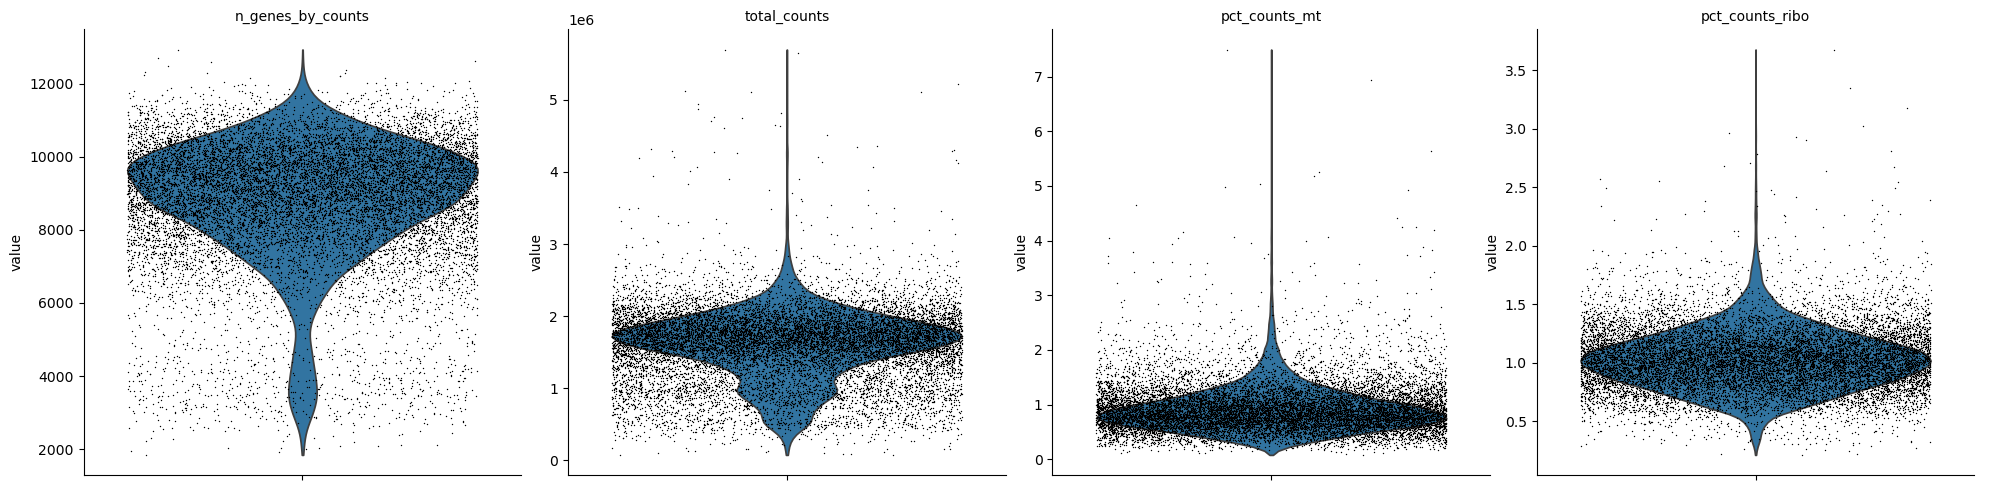

human


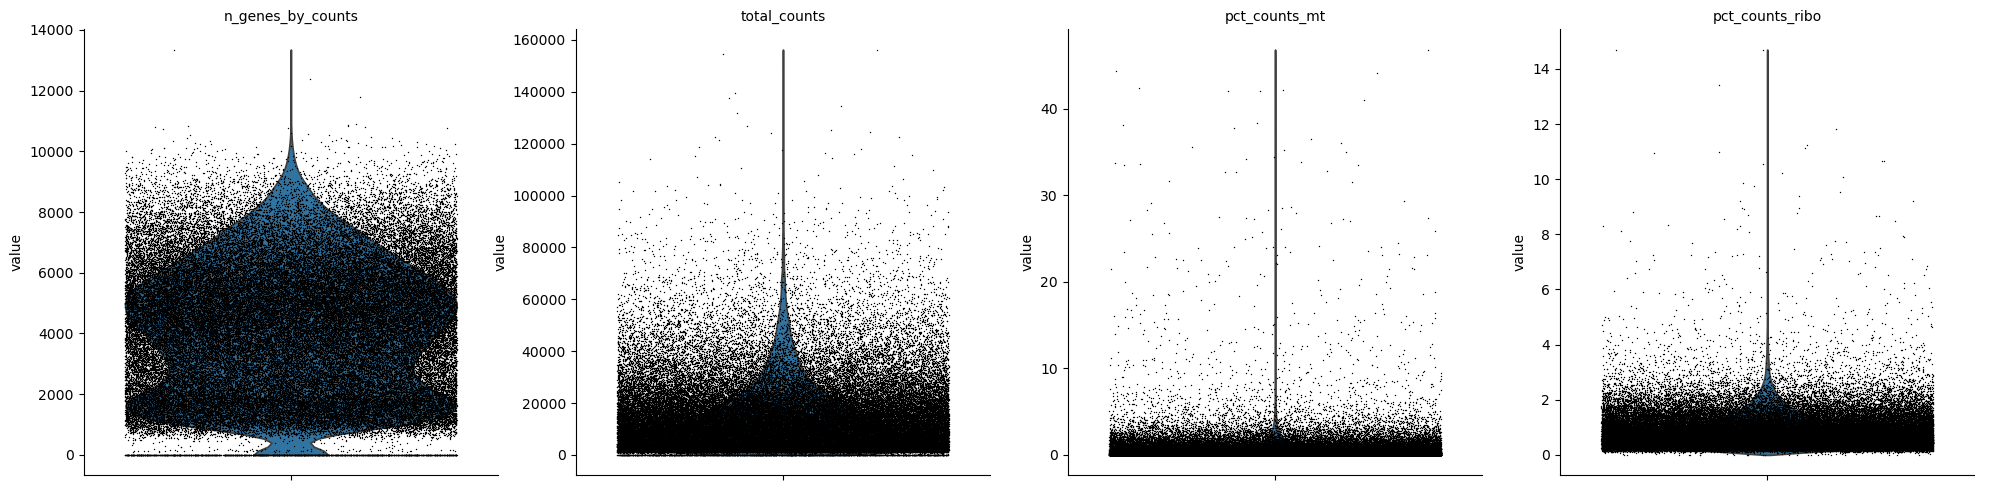

nmr


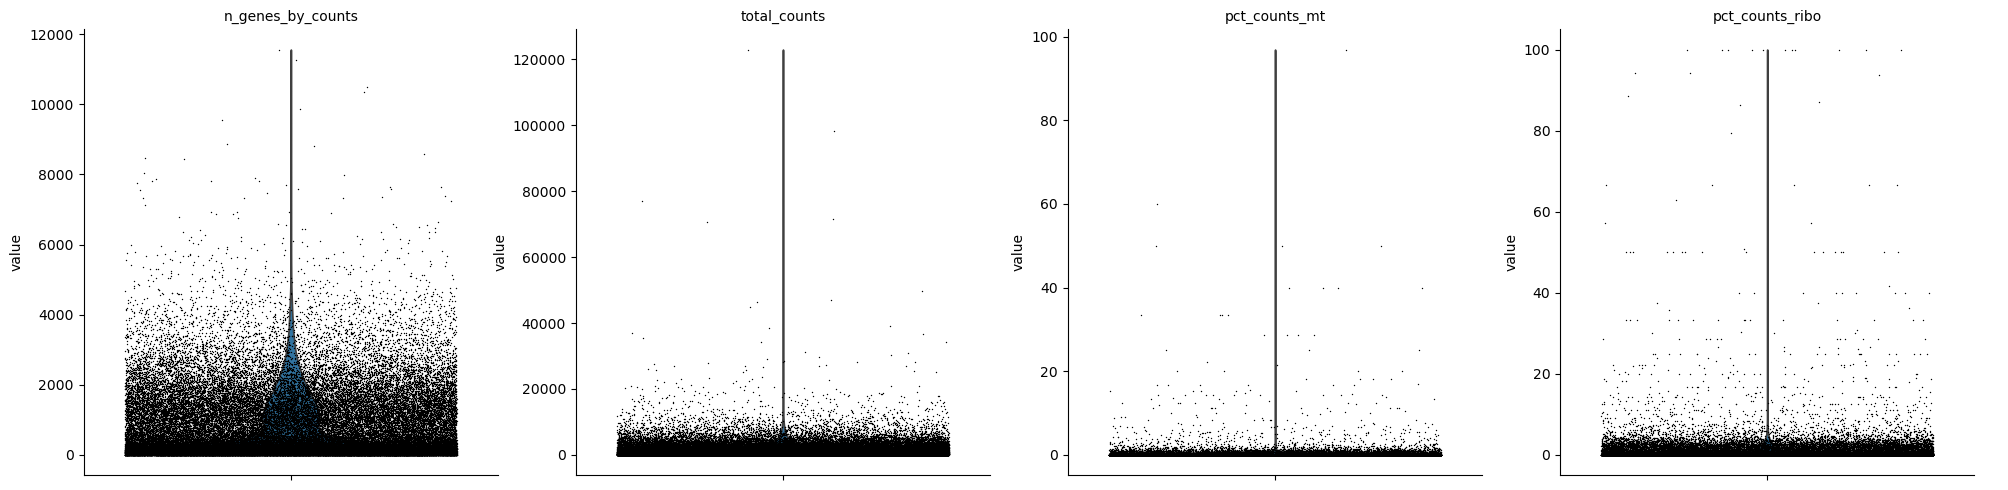

human


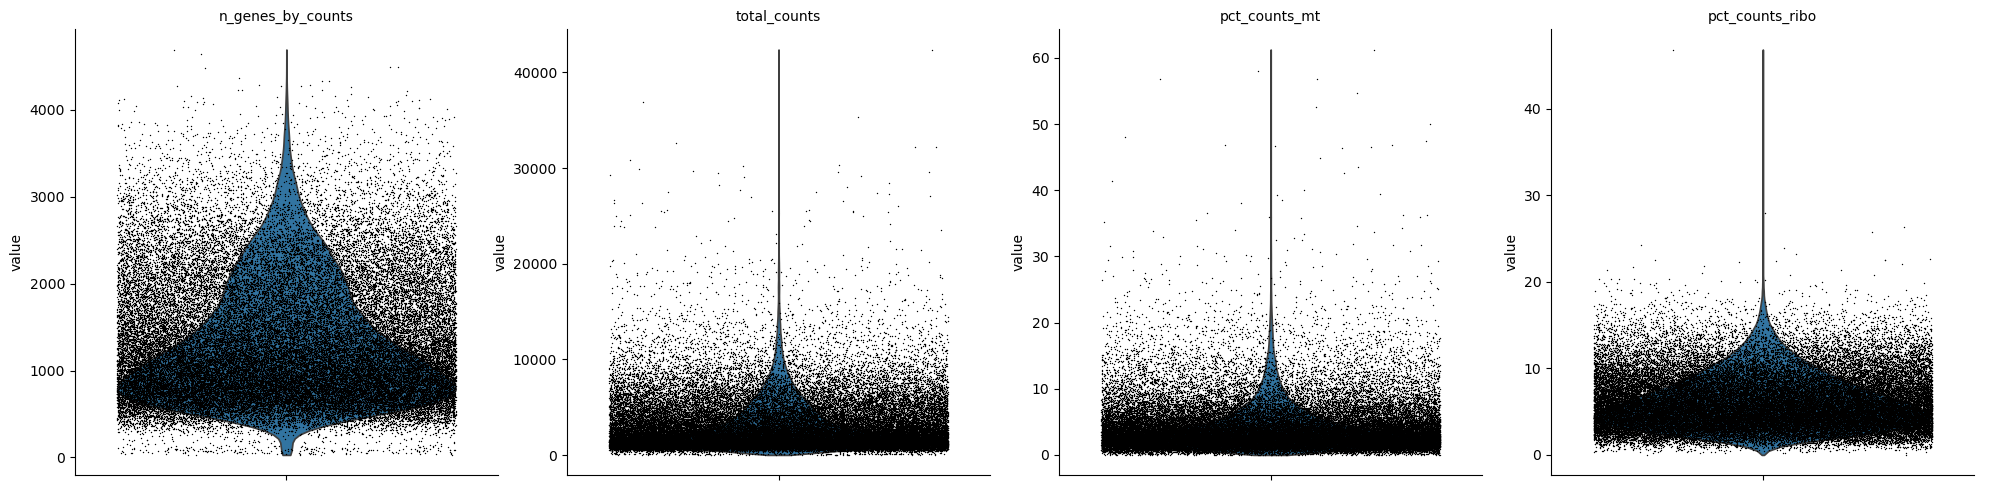

In [52]:
for adata in [mouse_data,human_data,nmr_data, dev_human]:
    print(adata.obs['species'][0])
    sc.pl.violin(
        adata,
        ["n_genes_by_counts", "total_counts", "pct_counts_mt", 'pct_counts_ribo'],
        jitter=0.4,
        multi_panel=True,
    )

In [53]:
nmr_data.obs

,species,tissue,sample_id,replicate,sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo
TCGCTTGGTCATCCCT-1-NMR2,nmr,cerebral_cortex,2,2,NMR2,8820,9.084891,44836.0,10.710789,7.801766,12.142029,18.491837,31.813721,46.0,3.850148,0.102596,378.0,5.937536,0.843073
AACAACCCACAAGCCC-1-NMR2,nmr,cerebral_cortex,2,2,NMR2,7324,8.899048,28299.0,10.250617,9.138132,14.095904,21.032545,34.683204,16.0,2.833213,0.056539,142.0,4.962845,0.501785
ACGTACAGTGATGGCA-1-NMR2,nmr,cerebral_cortex,2,2,NMR2,7688,8.947546,27593.0,10.225354,8.353568,12.861958,19.472330,32.432139,35.0,3.583519,0.126844,220.0,5.398163,0.797304
TTCCACGAGCACCGTC-1-NMR2,nmr,cerebral_cortex,2,2,NMR2,7574,8.932609,27076.0,10.206440,8.151130,12.483380,19.005762,32.024671,28.0,3.367296,0.103413,253.0,5.537334,0.934407
CAGATACGTATTGGCT-1-NMR2,nmr,cerebral_cortex,2,2,NMR2,6932,8.844048,25839.0,10.159679,12.097991,17.713534,24.946786,38.314176,25.0,3.258097,0.096753,135.0,4.912655,0.522466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CATTCTACATAGTCGT-1-NMR6,nmr,midbrain,6,2,NMR6,5,1.791759,31.0,3.465736,100.000000,100.000000,100.000000,100.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
GACATCATCATGAGTC-1-NMR6,nmr,midbrain,6,2,NMR6,3,1.386294,24.0,3.218876,100.000000,100.000000,100.000000,100.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
TTGTGGATCTGGGCGT-1-NMR6,nmr,midbrain,6,2,NMR6,1,0.693147,27.0,3.332205,100.000000,100.000000,100.000000,100.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
TGGTACATCCGGACGT-1-NMR6,nmr,midbrain,6,2,NMR6,6,1.945910,26.0,3.295837,100.000000,100.000000,100.000000,100.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000


In [54]:
# See cells that will be droped out by a basic filtering
print('n_genes_by_counts <= 30:\n',nmr_data.obs[nmr_data.obs['n_genes_by_counts']<=30].value_counts('sample'))
print('\nlog1p_total_counts <= 4:\n',nmr_data.obs[nmr_data.obs['log1p_total_counts']<=4].value_counts('sample'))
print('\nlog1p_total_counts > 10:\n',nmr_data.obs[nmr_data.obs['log1p_total_counts']>10].value_counts('sample'))
print('\npct_counts_mt > 5 :\n',nmr_data.obs[nmr_data.obs['pct_counts_mt']>5].value_counts('sample'))
print('\npct_counts_ribo > 7 :\n',nmr_data.obs[nmr_data.obs['pct_counts_ribo']>7].value_counts('sample'))



n_genes_by_counts <= 30:
 sample
NMR6    5298
NMR5    2342
NMR2     107
NMR3      63
NMR1       0
NMR4       0
Name: count, dtype: int64

log1p_total_counts <= 4:
 sample
NMR6    5636
NMR5    2816
NMR2     204
NMR3      77
NMR1       0
NMR4       0
Name: count, dtype: int64

log1p_total_counts > 10:
 sample
NMR3    30
NMR4     9
NMR2     8
NMR1     1
NMR5     0
NMR6     0
Name: count, dtype: int64

pct_counts_mt > 5 :
 sample
NMR5    112
NMR6     68
NMR1      3
NMR2      2
NMR3      2
NMR4      1
Name: count, dtype: int64

pct_counts_ribo > 7 :
 sample
NMR6    331
NMR5    318
NMR1      3
NMR4      2
NMR2      1
NMR3      1
Name: count, dtype: int64


In [55]:
print('\nlog1p_total_counts > 15:\n',mouse_data.obs[mouse_data.obs['log1p_total_counts']>15].value_counts('cell_supertype'))



log1p_total_counts > 15:
 cell_supertype
MGE interneuron                      29
Deep-layer corticothalamic and 6b    16
CGE interneuron                       5
Upper-layer intratelencephalic        5
Deep-layer intratelencephalic         4
Vascular                              1
Deep-layer near-projecting            1
Miscellaneous                         1
Astrocyte                             0
Fibroblast                            0
Oligodendrocyte                       0
Name: count, dtype: int64


In [56]:
# Filter out low-quality cells in mouse data
mouse_data = mouse_data[mouse_data.obs['log1p_total_counts'] < 15,:]
mouse_data = mouse_data[mouse_data.obs['pct_counts_mt'] < 5,:]
mouse_data = mouse_data[mouse_data.obs['pct_counts_ribo'] < 7,:]
mouse_data.shape

(14181, 34617)

In [57]:
# Filter out low-quality cells in human data
human_data = human_data[human_data.obs['log1p_total_counts'] > 4,:]
human_data = human_data[human_data.obs['log1p_total_counts'] < 10,:]
human_data = human_data[human_data.obs['pct_counts_mt'] < 5,:]
human_data = human_data[human_data.obs['pct_counts_ribo'] < 7,:]
human_data.shape

(62722, 33538)

In [58]:
# Filter out low-quality cells in nmr data
nmr_data = nmr_data[nmr_data.obs['log1p_total_counts'] > 4,:]
nmr_data = nmr_data[nmr_data.obs['log1p_total_counts'] < 10,:]
nmr_data = nmr_data[nmr_data.obs['pct_counts_mt'] < 3,:]
nmr_data = nmr_data[nmr_data.obs['pct_counts_ribo'] < 7,:]
nmr_data.shape

(57171, 20774)

In [59]:
# Filter out low-quality cells in human dev data
dev_human = dev_human[dev_human.obs['log1p_total_counts'] > 4,:]
dev_human = dev_human[dev_human.obs['log1p_total_counts'] < 10,:]
nmr_data = nmr_data[nmr_data.obs['pct_counts_mt'] < 5,:]
dev_human = dev_human[dev_human.obs['pct_counts_ribo'] < 7,:]
dev_human.shape

(35493, 8507)

mouse


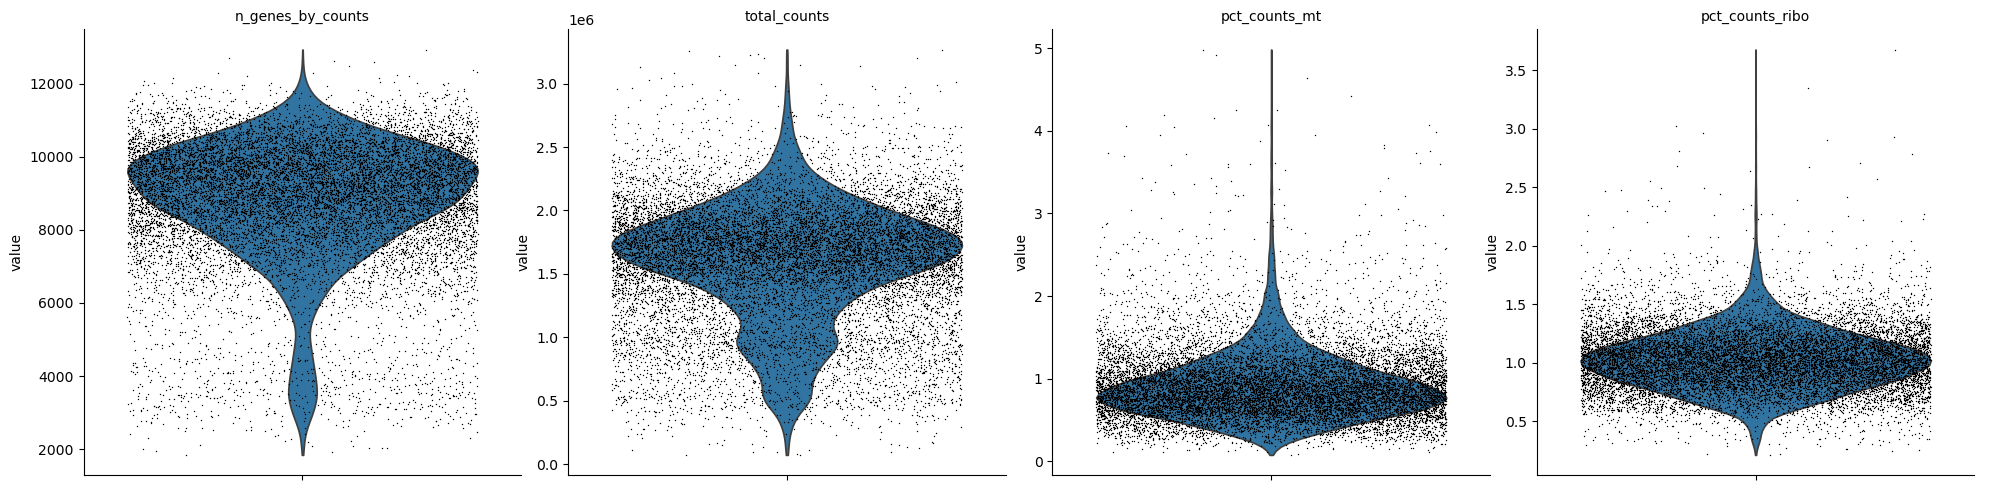

human


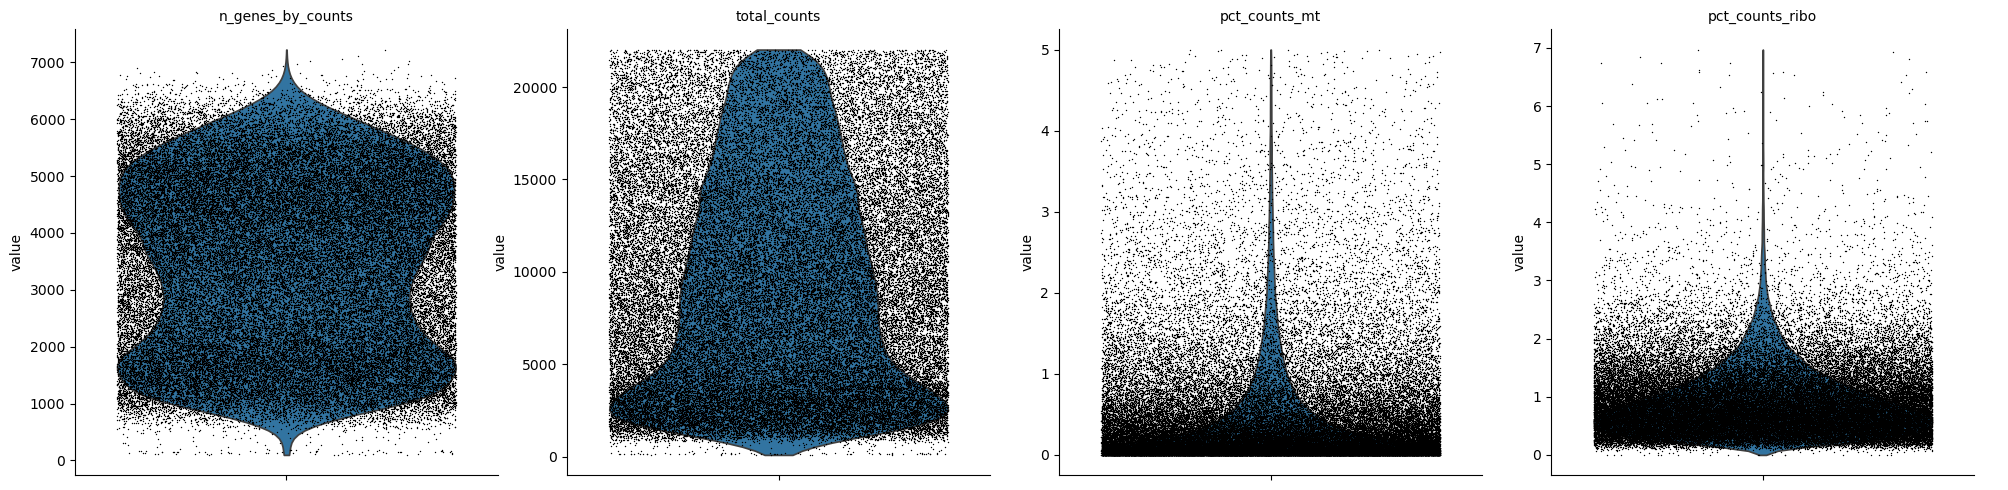

nmr


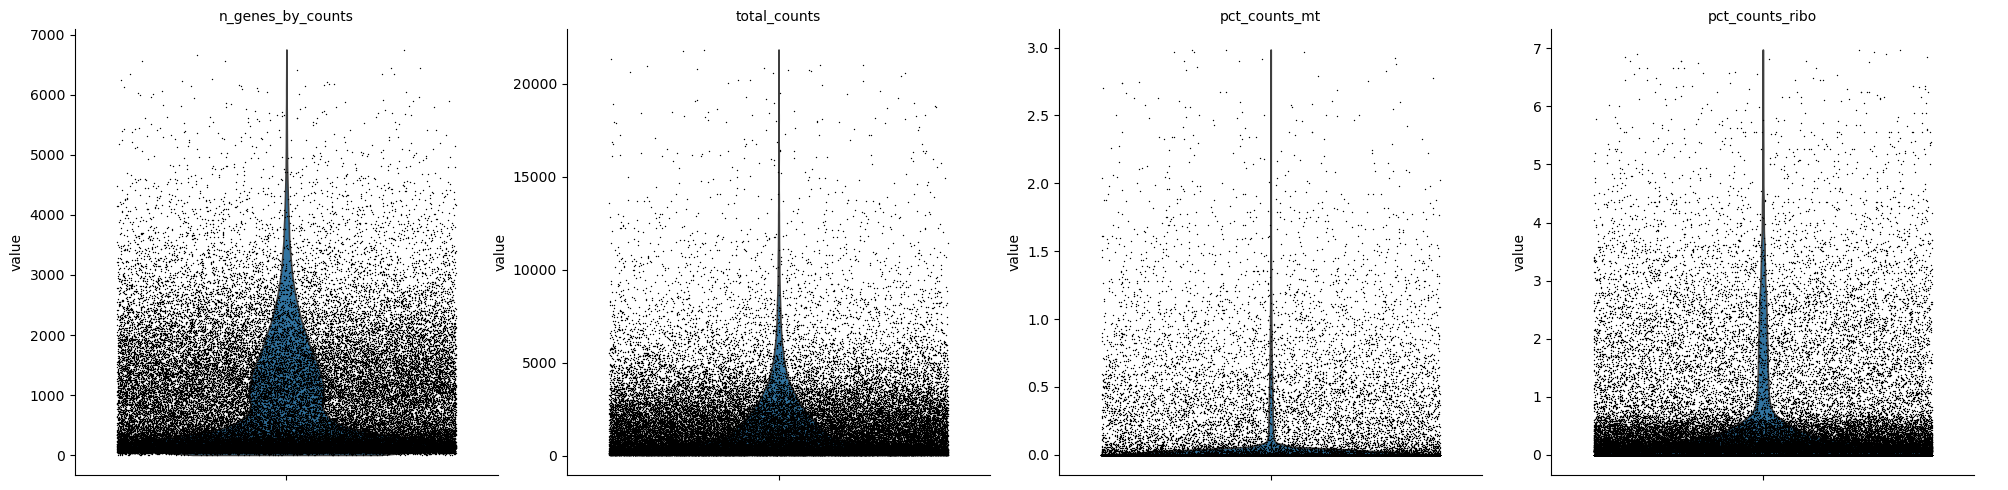

human


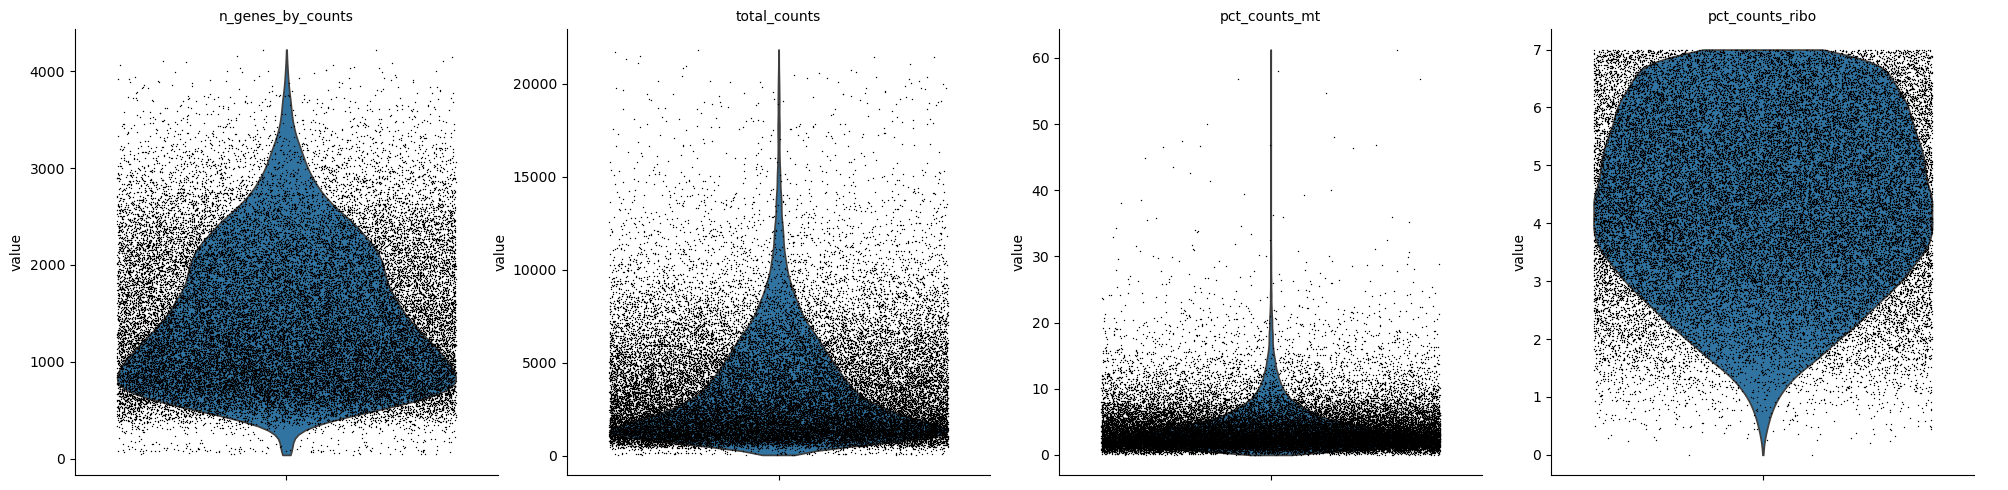

In [60]:
for adata in [mouse_data,human_data,nmr_data, dev_human]:
    print(adata.obs['species'][0])
    sc.pl.violin(
        adata,
        ["n_genes_by_counts", "total_counts", "pct_counts_mt", 'pct_counts_ribo'],
        jitter=0.4,
        multi_panel=True,
    )

## Normalize + log1p each dataset

In [61]:
# Save a temporal copy just in case
mo = mouse_data.copy()
hu = human_data.copy()
nm = nmr_data.copy()
dh = dev_human.copy()


In [64]:
# Run to go back to this checkpoint
mouse_data,human_data,nmr_data, dev_human = (mo,hu,nm,dh)

In [ ]:
for adata in [mouse_data,human_data,nmr_data, dev_human]:
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=10000, subset=True) # lots of top genes to ensure decent gene overlap

## Subset each dataset.var by only shared genes by at least 2 species

In [66]:
# Find intersection of global_name across all datasets
mouse_genes = set(mouse_data.var['global_name'].dropna())
human_genes = set(human_data.var['global_name'].dropna())
nmr_genes = set(nmr_data.var['global_name'].dropna())

shared_genes = mouse_genes & human_genes & nmr_genes
print(f"Number of shared genes by global_name: {len(shared_genes)}")
print(f"Number of shared genes between human and nmr: {len(human_genes & nmr_genes)}")
print(f"Number of shared genes between mouse and human: {len(mouse_genes & human_genes)}")
print(f"Number of shared genes between mouse and nmr: {len(mouse_genes & nmr_genes)}")
any_shared_genes = (human_genes & nmr_genes) | (mouse_genes & nmr_genes)
print(f"Number of genes shared by at least two species: {len(any_shared_genes)}")


Number of shared genes by global_name: 999
Number of shared genes between human and nmr: 1862
Number of shared genes between mouse and human: 1413
Number of shared genes between mouse and nmr: 1806
Number of genes shared by at least two species: 2669


## Merge datasets from different species

- Perform batch correction per species

- Helper functions

- Main metrics builder

- Majority-vote assignment (assign cluster majority to all cells)

- Cross-validation: mask 20% of annotated human+mouse and evaluate


In [69]:
# Subset each dataset to shared global_name genes
mouse_data_shared = mouse_data[:, mouse_data.var['global_name'].isin(any_shared_genes)]
human_data_shared = human_data[:, human_data.var['global_name'].isin(any_shared_genes)]
nmr_data_shared = nmr_data[:, nmr_data.var['global_name'].isin(any_shared_genes)]
dev_human_shared = dev_human[:, dev_human.var['global_name'].isin(any_shared_genes)]

In [70]:
# reorder columns to match
shared_genes_sorted = sorted(any_shared_genes)
mouse_data_shared = mouse_data_shared[:, mouse_data_shared.var['global_name'].isin(shared_genes_sorted)]
human_data_shared = human_data_shared[:, human_data_shared.var['global_name'].isin(shared_genes_sorted)]
nmr_data_shared = nmr_data_shared[:, nmr_data_shared.var['global_name'].isin(shared_genes_sorted)]
dev_human_shared = dev_human[:, dev_human.var['global_name'].isin(shared_genes_sorted)]

In [71]:
mouse_data_shared

View of AnnData object with n_obs × n_vars = 14181 × 1806
    obs: 'label', 'sizeFactor', 'subclass', 'n_counts', 'species', 'cell_type', 'cell_supertype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells', 'global_name', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '_from_cache', 'age_days', 'brain_hemisphere', 'brain_region', 'brain_subregion', 'ccc_target', 'class', 'cluster', 'cluster_correlation', 'complexity_cg', 'confusion_score', 'core_intermediate_call', 'donor', 'driver_lines', 'eye_condition', 'facs_container', 'facs_d

In [72]:
nmr_data_shared

View of AnnData object with n_obs × n_vars = 57171 × 2669
    obs: 'species', 'tissue', 'sample_id', 'replicate', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'genome', 'feature_types', 'species', 'global_name', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [73]:
human_data_shared

View of AnnData object with n_obs × n_vars = 62722 × 1862
    obs: 'Tissue', 'TotalUMIs', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'dissection', 'total_UMIs', 'sample_id', 'cluster_id', 'roi', 'cell_type', 'cell_supertype', 'species', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'Chromosome', 'End', 'Gene', 'Start', 'Strand', 'global_name', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', '

In [74]:
dev_human_shared

View of AnnData object with n_obs × n_vars = 35493 × 2323
    obs: 'Age', 'CellClass', 'Chemistry', 'Region', 'Subregion', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'tissue_type', 'dissection', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'fraction_mitochondrial', 'fraction_unspliced', 'cell_cycle_score', 'total_genes', 'total_UMIs', 'sample_id', 'cluster_id', 'species', 'cell_type', 'cell_supertype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'Accession', 'Chromosome', 'End', 'GeneTotalUMIs', 'Start', 

In [75]:
adata_list = [mouse_data_shared, human_data_shared, nmr_data_shared, dev_human_shared]
for i, ad in enumerate(adata_list):
    print(f"adata {i} var_names head:\n", ad.var_names[:10],'\n')


adata 0 var_names head:
 Index(['2700049A03Rik', '2810459M11Rik', 'A830018L16Rik', 'AU021092', 'Aass',
       'Abat', 'Abca1', 'Abca8a', 'Abcc3', 'Abcc6'],
      dtype='object') 

adata 1 var_names head:
 Index(['ENSG00000162576', 'ENSG00000175756', 'ENSG00000162496',
       'ENSG00000142627', 'ENSG00000117122', 'ENSG00000117115',
       'ENSG00000179051', 'ENSG00000159423', 'ENSG00000162542',
       'ENSG00000117298'],
      dtype='object', name='Accession') 

adata 2 var_names head:
 Index(['ZMYND10', 'ECT2', 'SLC26A6', 'CDHR4', 'GOLIM4', 'KIF15', 'SLC25A20',
       'CPB1', 'SPATA16', 'ALAS1'],
      dtype='object') 

adata 3 var_names head:
 Index(['MXRA8', 'AURKAIP1', 'GABRD', 'PRDM16', 'MEGF6', 'TP73', 'VAMP3',
       'AGTRAP', 'TNFRSF1B', 'DHRS3'],
      dtype='object', name='global_name') 



In [76]:
# Setting global_name as var_names for each dataset
for ad in adata_list:
    if "global_name" in ad.var.columns:
        ad.var_names = ad.var["global_name"].astype(str)

In [77]:
# Now see how var_names ended up
for i, ad in enumerate(adata_list):
    print(f"adata {i} var_names head:\n", ad.var_names[:10],'\n')

adata 0 var_names head:
 Index(['KIAA0586', 'C2orf72', 'C8orf34', 'C16orf89', 'AASS', 'ABAT', 'ABCA1',
       'ABCA8', 'ABCC3', 'ABCC6'],
      dtype='object', name='global_name') 

adata 1 var_names head:
 Index(['MXRA8', 'AURKAIP1', 'DHRS3', 'EPHA2', 'MFAP2', 'PADI2', 'RCC2',
       'ALDH4A1', 'TMCO4', 'ECE1'],
      dtype='object', name='global_name') 

adata 2 var_names head:
 Index(['ZMYND10', 'ECT2', 'SLC26A6', 'CDHR4', 'GOLIM4', 'KIF15', 'SLC25A20',
       'CPB1', 'SPATA16', 'ALAS1'],
      dtype='object', name='global_name') 

adata 3 var_names head:
 Index(['MXRA8', 'AURKAIP1', 'GABRD', 'PRDM16', 'MEGF6', 'TP73', 'VAMP3',
       'AGTRAP', 'TNFRSF1B', 'DHRS3'],
      dtype='object', name='global_name') 



In [78]:
# Check for duplicated genes before merging
human_duplicates = human_data_shared.var['global_name'][human_data_shared.var['global_name'].duplicated()]
print('Human adult duplicates:',human_duplicates)

nmr_duplicates = nmr_data_shared.var['global_name'][nmr_data_shared.var['global_name'].duplicated()]
print('NMR duplicates:',nmr_duplicates)

mouse_duplicates = mouse_data_shared.var['global_name'][mouse_data_shared.var['global_name'].duplicated()]
print('Mouse duplicates:',mouse_duplicates)

Human adult duplicates: Series([], Name: global_name, dtype: category
Categories (1862, object): ['1700034E13Rik', 'AAMDC', 'AASS', 'AATF', ..., 'ZNF521', 'ZNF536', 'ZNF608', 'ZNF703'])
NMR duplicates: Series([], Name: global_name, dtype: category
Categories (2669, object): ['1700034E13Rik', 'AAMDC', 'AASS', 'AATF', ..., 'ZNF750', 'ZP3', 'ZPLD1', 'Zfp663'])
Mouse duplicates: Series([], Name: global_name, dtype: category
Categories (1806, object): ['AASS', 'ABAT', 'ABCA1', 'ABCA8', ..., 'ZNF750', 'ZP3', 'ZPLD1', 'Zfp663'])


In [79]:
mouse_data_shared.var[mouse_data_shared.var['global_name'].isin(mouse_duplicates)]

,n_cells,global_name,mt,ribo,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,highly_variable,means,dispersions,dispersions_norm
global_name,,,,,,,,,,,,,,


In [80]:
human_data_shared.var[human_data_shared.var['global_name'].isin(human_duplicates.values)]

,Chromosome,End,Gene,Start,Strand,global_name,mt,ribo,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,highly_variable,means,dispersions,dispersions_norm
global_name,,,,,,,,,,,,,,,,,,


In [81]:
nmr_data_shared.var[nmr_data_shared.var['global_name'].isin(nmr_duplicates.values)]

,gene_ids,genome,feature_types,species,global_name,mt,ribo,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,highly_variable,means,dispersions,dispersions_norm
global_name,,,,,,,,,,,,,,,,,


In [82]:
from scipy import sparse

def drop_lower_count_duplicates(adata, gene_key="global_name", verbose=True):
    """
    Remove duplicated genes by keeping the one with highest global expression.
    Prints info about duplicates if verbose=True.
    
    Parameters
    ----------
    adata : AnnData
    gene_key : str
        Column in `adata.var` to identify gene names (default "global_name").
    verbose : bool
        If True, print duplicate genes and their counts.
    
    Returns
    -------
    AnnData with unique genes
    """
    # Get gene names
    if gene_key in adata.var.columns:
        genes = adata.var[gene_key].astype(str)
    else:
        genes = adata.var_names.astype(str)

    # Compute total counts per gene (sparse-aware)
    if sparse.issparse(adata.X):
        total_counts = np.array(adata.X.sum(axis=0)).flatten()
    else:
        total_counts = adata.X.sum(axis=0)

    # Build dataframe
    df = pd.DataFrame({
        "gene": genes.values,
        "total_counts": total_counts,
        "idx": np.arange(len(genes))
    })

    # Find duplicates
    dupes = df[df.duplicated("gene", keep=False)].sort_values("gene")

    if verbose and not dupes.empty:
        print("\nDuplicate genes found:")
        for g, sub in dupes.groupby("gene"):
            print(f"  {g}:")
            for _, row in sub.iterrows():
                print(f"    idx={row['idx']} total_counts={row['total_counts']}")
    
    # Keep max count per gene
    keep_idx = df.loc[df.groupby("gene")["total_counts"].idxmax(), "idx"].values

    # Subset AnnData
    adata_unique = adata[:, keep_idx].copy()
    adata_unique.var_names = genes.iloc[keep_idx].values

    return adata_unique


In [83]:
mouse_clean = drop_lower_count_duplicates(mouse_data_shared, gene_key="global_name")

print("Before:", mouse_data_shared.shape)
print("After:", mouse_clean.shape)

Before: (14181, 1806)
After: (14181, 1806)


In [84]:
human_clean = drop_lower_count_duplicates(human_data_shared, gene_key="global_name")

print("Before:", human_data_shared.shape)
print("After:", human_clean.shape)

Before: (62722, 1862)
After: (62722, 1862)


In [85]:
nmr_clean = drop_lower_count_duplicates(nmr_data_shared, gene_key="global_name")
print("Before:", nmr_data_shared.shape)
print("After:", nmr_clean.shape)

Before: (57171, 2669)
After: (57171, 2669)


In [86]:
dev_human_clean = drop_lower_count_duplicates(dev_human_shared, gene_key="global_name")

print("Before:", dev_human_shared.shape)
print("After:", dev_human_clean.shape)

Before: (35493, 2323)
After: (35493, 2323)


In [87]:
outer_merged = sc.concat(
    [mouse_clean, nmr_clean, human_clean, dev_human_clean],
    join="outer", 
    merge="same",
    label="dataset_name",
    keys=["mouse", "nmr", "human", "human_dev"],
    fill_value=0
)

print("Merged AnnData (outer):", outer_merged.shape)

Merged AnnData (outer): (169567, 2669)


In [88]:
outer_merged.obs['dataset_name'].value_counts()

dataset_name
human        62722
nmr          57171
human_dev    35493
mouse        14181
Name: count, dtype: int64

In [89]:
## CHECKPOINT
filename = '/home/raquelcr/scanpy/all_adata_outer2.h5ad'
outer_merged.write_h5ad(filename)
print(f"AnnData object successfully saved to {filename}")

AnnData object successfully saved to /home/raquelcr/scanpy/all_adata_outer2.h5ad


In [90]:
outer_merged = sc.read(filename)